<a href="https://colab.research.google.com/github/sumit0yadav/DiseasePredictor/blob/main/BDT-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install uproot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.5/363.5 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.4/871.4 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 23.4 MB/s eta 0:00:00


In [11]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc



"""
Designing boosted decision tree for the classification of tau hadronic decay and hard QCD jets

variable to use :  theta_J and N_T initially to segment phase space and then use lambda_J, r_2 and tau_31 to analyze the subspaces using multi-variate analysis
files given  : signal (tauhadronic_out.root) and background (hardqcd_200k_minpt50_out.root)
"""
variables = ["thetaJ", "trackno", "LambdaJ", "ecfr2", "tau31"] #



def create_df(file_name, label):
    file = uproot.open(f"/content/{file_name}.root")  # Corrected path
    tree_name = list(file.keys())[0]
    tree = file[tree_name]
    df = tree.arrays(library="pd")[variables]
    df["label"] = label
    return df

#create a parquet file from the root file
def write_parquet(file_name):
    file  = uproot.open(f"/content/{file_name}.root")  # Corrected path
    print(file.keys())
    tree_name = list(file.keys())[0]
    tree = file[tree_name]
    df = tree.arrays(library="pd")
    df.to_parquet(f"/content/converted_{file_name}.parquet", index=False)  # Save in /content/
    print(f"saved {file_name}.parquet")
    return


if __name__ == "__main__":

    signal_file = "tauhadronic1L_minpt50_out"
    background_file = "hardqcd_200k_minpt50_out2"

    # write_parquet(signal_file)
    # write_parquet(background_file)

    signal_df = create_df(signal_file, 1)
    background_df = create_df(background_file, 0)

    print(len(signal_df), len(background_df))

    # write_parquet(signal_file)
    write_parquet(background_file)

    df = pd.concat([signal_df, background_df], axis=0)
    df = df.sample(frac=1).reset_index(drop=True)

    X = df[variables]
    y = df["label"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")









27956 97708
['TreeB;1']
saved hardqcd_200k_minpt50_out2.parquet
Training samples: 100531, Testing samples: 25133


In [12]:
df.head()

,thetaJ,trackno,LambdaJ,ecfr2,tau31,label
0,-0.566324,1.0,-0.391140,7.871248e-08,0.000000,1
1,-0.000003,5.0,-0.451036,2.894400e-01,0.088920,0
2,-0.132923,2.0,-0.403285,1.654405e-01,0.089534,1
3,-0.107852,0.0,-0.482886,4.117105e-01,0.357072,1
4,-0.134519,1.0,-0.550678,1.677789e-03,0.000033,1


In [13]:
df.columns

Index(['thetaJ', 'trackno', 'LambdaJ', 'ecfr2', 'tau31', 'label'], dtype='object')

In [14]:
signal_df.columns

Index(['thetaJ', 'trackno', 'LambdaJ', 'ecfr2', 'tau31', 'label'], dtype='object')

In [15]:
background_df.columns

Index(['thetaJ', 'trackno', 'LambdaJ', 'ecfr2', 'tau31', 'label'], dtype='object')

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb



# Features and labels
X = df.drop(columns=["label"])
y = df["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

# Grid Search Hyperparameters
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0]
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model and predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:46:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Accuracy: 0.9682
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     19569
           1       0.94      0.92      0.93      5564

    accuracy                           0.97     25133
   macro avg       0.96      0.95      0.95     25133
weighted avg       0.97      0.97      0.97     25133



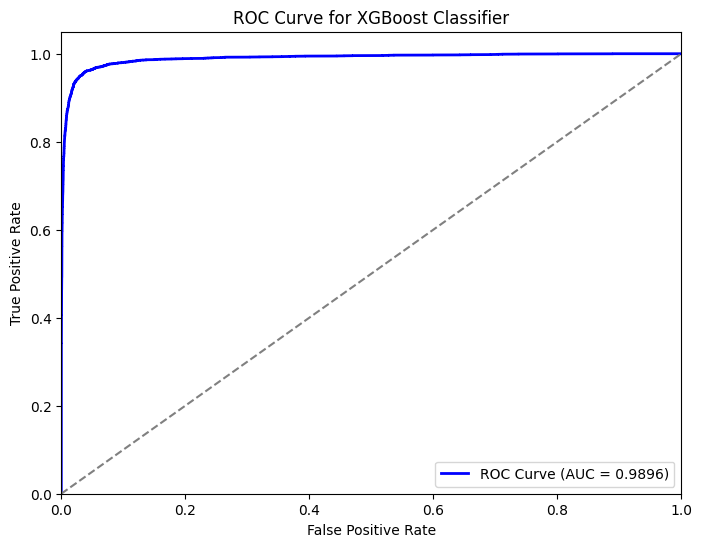

In [18]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost Classifier")
plt.legend(loc="lower right")
plt.show()

In [22]:
sample_idx = np.random.randint(0, len(X_test), 5)
sample_X = X_test.iloc[sample_idx]
sample_y = y_test.iloc[sample_idx]

print("Actual Labels:", sample_y.values)
print("Predicted Labels:", best_model.predict(sample_X))
print("Predicted Probabilities:", best_model.predict_proba(sample_X)[:, 1])


Actual Labels: [1 0 0 0 0]
Predicted Labels: [1 0 0 0 0]
Predicted Probabilities: [9.8609155e-01 4.6742028e-03 2.8765269e-04 2.0389438e-04 3.3444053e-04]
